In [8]:
%matplotlib inline
import os
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.plot import plotting_extent
import xarray as xr
import salem
import h5py
import pyproj

import multiprocessing
from joblib import Parallel, delayed

In [2]:
files = glob.glob('/home/ubuntu/data/1km_gan_wind/*.h5')
files

['/home/ubuntu/data/1km_gan_wind/2012.h5',
 '/home/ubuntu/data/1km_gan_wind/2010.h5',
 '/home/ubuntu/data/1km_gan_wind/2008.h5',
 '/home/ubuntu/data/1km_gan_wind/2011.h5',
 '/home/ubuntu/data/1km_gan_wind/2009.h5',
 '/home/ubuntu/data/1km_gan_wind/2013.h5',
 '/home/ubuntu/data/1km_gan_wind/2007.h5']

In [3]:
def hdf_to_netcdf(f, projstring):
    """
    save hdf5 WRF output in lcc projection to netcdf with lcc coordinate
    """
    data = f['windspeed_mph']
    
    projectLcc = pyproj.Proj(projstring)
    origin_ll = reversed((f['lat'][0, 0], f['lon'][0, 0]))  # Grab origin directly from database
    origin = projectLcc(*origin_ll)  #origin point 

    # Grid parameters
    dx, dy = 1000, 1000
    ny, nx = f['lat'].shape

    # 2d grid
    x = np.arange(nx) * dx + origin[0]  # x coordinate in lcc projection
    y = np.arange(ny) * dy + origin[1]  # y coordinate in lcc projection
    xx, yy = np.meshgrid(x, y)   # x, y rectangle meshgrid  (This is not used, only for validation purpose)
    
    ## save to netcdf
    datetime = pd.to_datetime([x.decode("utf-8") for x in f['datetime']])  ## time convert from binary to datetime64 format
    
    ds = xr.DataArray(data[:].astype(np.float32),
                     dims = ('date', 'y', 'x'),
                     coords = {'date': datetime,
                              'x': x,
                              'y': y},
                     name = 'windspeed',
                    ## attributes 
                     attrs = {'Unit': 'm/s',
                              'res': '[0.00898315 0.00898315]',
                              'description': 'windspeed at 10m',
                              'pyproj_srs': projstring})
    
    return ds

In [4]:
def daily_max(ds, projstring):
    """
    hourly netcdf to daily with max value
    
    """
    
    ds_daily = ds.resample(date='24H').max()
    
    ds_daily = ds_daily.rename({'date': 'day'})
    
    ## re-add attributes (important, especially the pyproj_srs)
    ds_daily.attrs['pyproj_srs'] = projstring
    ds_daily.attrs['unit'] = 'm/s'
    ds_daily.attrs['description'] = "Windspeed at 10m"
    ds_daily.name = 'windspeed'
    
    
    return ds_daily

In [5]:
def reproject_WRF(file, t_file, spath=None):
    """
    reproject hdf5 images in lcc projection to lat/lon WGS84 
    
    input:
        file: hdf5 file in LCC projection
        t_file: target image, the target image that you want to interpolate to the same extent, 
                same projection and same resolution
                
                (here a random 1km gridmet image, in lat/lon WGS84 coordinate is choose)
        spath: the directory that you want to save your final output
                
    output: reprojected netcdf
    """
    
    f = h5py.File(file, 'r')
    f_name = file.split('/')[-1].split('.')[0]
    
    ## get coordinate in lcc projection
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                +lat_0=38.47240422490422 +lon_0=-96.0 
                +x_0=0 +y_0=0 +ellps=sphere 
                +units=m +no_defs 
             """
    ## hdf5 to netcdf
    ds = hdf_to_netcdf(f, projstring)
    f.close()
    
    ## hourly to daily
    ds_daily = daily_max(ds, projstring)
    
    ## target image
    t_f = xr.open_dataarray(t_file)
    ds_t = t_f.salem.transform(ds_daily, interp='spline')
    t_f.close()
    
    if spath:
        ds_t.to_netcdf(os.path.join(spath, f_name + '.nc'))
        
    else:
        return ds_t

### Reproject multiple files 

In [ ]:
%%time
Parallel(n_jobs=16)(delayed(reproject_WRF)(file, '/home/ubuntu/data/gridmet_ca_1km/bi_2001.nc', 
                                           '/home/ubuntu/data/1km_gan_wind/nc') for file in files[0:-1])

In [ ]:
%%time
for file in tqdm(files[0:-1]):
    reproject_WRF(file, '/home/ubuntu/data/gridmet_ca_1km/bi_2001.nc', '/home/ubuntu/data/1km_gan_wind/nc')

/home/ubuntu/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel/__main__.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


### Test

In [6]:
projstring = """+proj=lcc +lat_1=30 +lat_2=60 
            +lat_0=38.47240422490422 +lon_0=-96.0 
            +x_0=0 +y_0=0 +ellps=sphere 
            +units=m +no_defs 
         """
f = h5py.File(files[-1], 'r')

In [23]:
%%time
ds = hdf_to_netcdf(f, projstring)
ds

CPU times: user 49.3 s, sys: 37.8 s, total: 1min 27s
Wall time: 1min 27s


<xarray.DataArray 'windspeed' (date: 8760, y: 1600, x: 1500)>
array([[[ 7.3320312 ,  7.3398438 ,  7.2695312 , ...,  0.7895508 ,
          0.87939453,  1.0175781 ],
        [ 7.171875  ,  7.2148438 ,  7.1445312 , ...,  0.69384766,
          0.7714844 ,  0.9086914 ],
        [ 7.2226562 ,  7.3007812 ,  7.2421875 , ...,  0.6274414 ,
          0.70703125,  0.86621094],
        ...,
        [ 8.5859375 ,  8.703125  ,  8.59375   , ...,  5.46875   ,
          5.4375    ,  5.3320312 ],
        [ 8.484375  ,  8.578125  ,  8.4609375 , ...,  5.4960938 ,
          5.5078125 ,  5.3320312 ],
        [ 8.3671875 ,  8.4375    ,  8.3125    , ...,  5.5351562 ,
          5.578125  ,  5.4960938 ]],

       [[ 7.9257812 ,  7.953125  ,  7.8789062 , ...,  2.6367188 ,
          2.65625   ,  2.6269531 ],
        [ 7.765625  ,  7.8203125 ,  7.7304688 , ...,  2.5683594 ,
          2.5820312 ,  2.5371094 ],
        [ 7.8320312 ,  7.9023438 ,  7.8164062 , ...,  2.5019531 ,
          2.5175781 ,  2.4921875 ],
        ...,
        [ 7.1210938 ,  7.234375  ,  7.1953125 , ...,  4.7070312 ,
          4.71875   ,  4.78125   ],
        [ 7.0976562 ,  7.2148438 ,  7.1796875 , ...,  4.8828125 ,
          4.9375    ,  4.9101562 ],
        [ 7.1132812 ,  7.2382812 ,  7.203125  , ...,  5.0546875 ,
          5.1953125 ,  5.1523438 ]],

       [[ 7.9101562 ,  7.8710938 ,  7.7070312 , ...,  3.0351562 ,
          2.9882812 ,  2.9316406 ],
        [ 7.7617188 ,  7.7304688 ,  7.5585938 , ...,  2.9648438 ,
          2.8964844 ,  2.8261719 ],
        [ 7.859375  ,  7.84375   ,  7.7148438 , ...,  2.8261719 ,
          2.7617188 ,  2.6894531 ],
        ...,
        [ 6.1367188 ,  6.2382812 ,  6.2226562 , ...,  4.4023438 ,
          4.34375   ,  4.4765625 ],
        [ 6.1367188 ,  6.234375  ,  6.2148438 , ...,  4.5976562 ,
          4.5585938 ,  4.6523438 ],
        [ 6.1445312 ,  6.2382812 ,  6.2148438 , ...,  4.7851562 ,
          4.7148438 ,  4.7851562 ]],

       ...,

       [[ 5.3398438 ,  5.3085938 ,  5.1796875 , ...,  4.3476562 ,
          4.2226562 ,  4.1523438 ],
        [ 5.2304688 ,  5.2539062 ,  5.1445312 , ...,  4.2890625 ,
          4.1875    ,  4.1523438 ],
        [ 5.265625  ,  5.359375  ,  5.296875  , ...,  4.2539062 ,
          4.1914062 ,  4.203125  ],
        ...,
        [ 9.875     ,  9.96875   ,  9.828125  , ...,  8.4296875 ,
          8.5859375 ,  8.6875    ],
        [ 9.890625  ,  9.984375  ,  9.84375   , ...,  8.578125  ,
          8.6328125 ,  8.5625    ],
        [ 9.90625   , 10.        ,  9.8515625 , ...,  8.90625   ,
          8.9609375 ,  9.0859375 ]],

       [[ 4.6601562 ,  4.578125  ,  4.3359375 , ...,  4.171875  ,
          4.125     ,  4.078125  ],
        [ 4.6640625 ,  4.6210938 ,  4.4335938 , ...,  4.09375   ,
          4.0703125 ,  4.0390625 ],
        [ 4.7851562 ,  4.8046875 ,  4.6875    , ...,  4.0429688 ,
          4.0390625 ,  4.0273438 ],
        ...,
        [ 9.8046875 ,  9.8828125 ,  9.7109375 , ..., 10.046875  ,
         10.265625  , 10.4453125 ],
        [ 9.8125    ,  9.890625  ,  9.71875   , ..., 10.1328125 ,
         10.328125  , 10.3203125 ],
        [ 9.828125  ,  9.90625   ,  9.734375  , ..., 10.0546875 ,
         10.28125   , 10.4140625 ]],

       [[ 4.4140625 ,  4.2617188 ,  4.078125  , ...,  3.6230469 ,
          3.7285156 ,  3.921875  ],
        [ 4.203125  ,  4.0585938 ,  3.859375  , ...,  3.6054688 ,
          3.7167969 ,  3.9375    ],
        [ 4.1054688 ,  3.9257812 ,  3.8085938 , ...,  3.6328125 ,
          3.7636719 ,  4.015625  ],
        ...,
        [ 9.640625  ,  9.703125  ,  9.5234375 , ...,  7.7304688 ,
          8.265625  ,  8.8359375 ],
        [ 9.65625   ,  9.7265625 ,  9.546875  , ...,  7.1367188 ,
          7.6992188 ,  8.1328125 ],
        [ 9.6796875 ,  9.7421875 ,  9.5703125 , ...,  6.3320312 ,
          6.9765625 ,  7.5273438 ]]], dtype=float32)
Coordinates:
  * date     (date) datetime64[ns] 2007-01-01 ... 2007-12-31T23:00:00
  * x        (x) float64 -2.575e+06 -2.574e+06 ... -1.077e+06 -1.

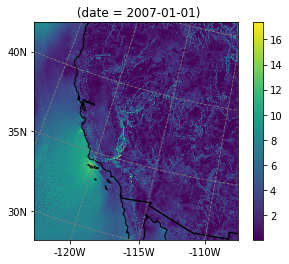

In [12]:
ds.isel(date=0).salem.quick_map()

In [24]:
%%time
ds_daily = daily_max(ds, projstring)
ds_daily

CPU times: user 51.2 s, sys: 2.77 s, total: 54 s
Wall time: 54 s


<xarray.DataArray 'windspeed' (day: 365, y: 1600, x: 1500)>
array([[[11.6015625, 11.9609375, 11.7734375, ...,  4.2148438,
          4.3046875,  4.3515625],
        [11.5859375, 11.75     , 11.359375 , ...,  4.3671875,
          4.4492188,  4.4882812],
        [11.6796875, 11.640625 , 11.0625   , ...,  4.4921875,
          4.5703125,  4.6054688],
        ...,
        [ 9.1953125,  9.25     ,  9.0234375, ...,  5.46875  ,
          5.4648438,  5.6367188],
        [ 9.5      ,  9.578125 ,  9.34375  , ...,  5.5234375,
          5.6679688,  5.703125 ],
        [ 9.5859375,  9.6640625,  9.390625 , ...,  5.6953125,
          5.7421875,  5.7382812]],

       [[11.046875 , 11.046875 , 10.703125 , ...,  8.203125 ,
          8.28125  ,  8.3046875],
        [11.046875 , 11.078125 , 10.734375 , ...,  8.265625 ,
          8.296875 ,  8.2890625],
        [11.2421875, 11.328125 , 11.0234375, ...,  8.328125 ,
          8.3203125,  8.296875 ],
        ...,
        [10.9609375, 11.078125 , 10.9296875, ...,  9.34375  ,
          9.3515625,  8.7421875],
        [10.9375   , 11.0546875, 10.90625  , ...,  9.1328125,
          8.5859375,  7.2265625],
        [10.9453125, 11.0625   , 10.90625  , ...,  8.9453125,
          7.5742188,  5.5664062]],

       [[ 6.0625   ,  6.1054688,  6.0820312, ...,  5.7734375,
          5.828125 ,  5.875    ],
        [ 5.9960938,  6.0625   ,  6.0273438, ...,  5.6523438,
          5.6953125,  5.7109375],
        [ 6.0820312,  6.1679688,  6.1289062, ...,  5.5234375,
          5.6328125,  5.7226562],
        ...,
        [10.3984375, 10.4921875, 10.3203125, ...,  6.4101562,
          5.7382812,  4.9140625],
        [10.390625 , 10.484375 , 10.3125   , ...,  7.2929688,
          6.5039062,  4.984375 ],
        [10.3828125, 10.4765625, 10.3125   , ...,  7.4648438,
          6.9765625,  7.1132812]],

       ...,

       [[10.03125  , 10.0625   ,  9.953125 , ...,  4.34375  ,
          4.203125 ,  4.0117188],
        [ 9.6875   ,  9.6796875,  9.546875 , ...,  4.625    ,
          4.4453125,  4.1953125],
        [ 9.6953125,  9.7265625,  9.71875  , ...,  4.8789062,
          4.7226562,  4.4804688],
        ...,
        [12.3671875, 12.546875 , 12.4609375, ...,  7.0859375,
          7.2265625,  7.2304688],
        [12.4609375, 12.6328125, 12.46875  , ...,  6.8984375,
          6.890625 ,  6.6640625],
        [12.546875 , 12.703125 , 12.5078125, ...,  6.8984375,
          6.7773438,  6.703125 ]],

       [[ 9.59375  ,  9.6015625,  9.3125   , ...,  4.5078125,
          4.3945312,  4.2617188],
        [ 9.4765625,  9.4296875,  9.046875 , ...,  4.5585938,
          4.4414062,  4.3164062],
        [ 9.5703125,  9.484375 ,  9.0234375, ...,  4.5859375,
          4.4960938,  4.40625  ],
        ...,
        [11.546875 , 11.9609375, 12.140625 , ...,  9.59375  ,
          9.53125  ,  9.40625  ],
        [11.7265625, 12.1015625, 12.25     , ...,  9.609375 ,
          9.515625 ,  9.3046875],
        [11.8359375, 12.171875 , 12.296875 , ...,  9.921875 ,
          9.6796875,  9.5703125]],

       [[ 9.7578125,  9.75     ,  9.484375 , ...,  4.3476562,
          4.2226562,  4.1523438],
        [ 9.578125 ,  9.5625   ,  9.234375 , ...,  4.2890625,
          4.1875   ,  4.1523438],
        [ 9.6015625,  9.5625   ,  9.21875  , ...,  4.2539062,
          4.1914062,  4.203125 ],
        ...,
        [ 9.875    ,  9.96875  ,  9.828125 , ..., 10.046875 ,
         10.265625 , 10.4453125],
        [ 9.890625 ,  9.984375 ,  9.84375  , ..., 10.1328125,
         10.328125 , 10.3203125],
        [ 9.90625  , 10.       ,  9.8515625, ..., 10.0546875,
         10.28125  , 10.4140625]]], dtype=float32)
Coordinates:
  * day      (day) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * x        (x) float64 -2.575e+06 -2.574e+06 ... -1.077e+06 -1.076e+06
  * y        (y) float64 -6.971e+05 -6.961e+05 ... 9.009e+05 9.019e+05
Attributes:
    pyproj_srs:   +proj=lcc +lat_1=30 +lat_2=60 \n            +lat_0=38.47240...
    unit:         m/s
    description:  Winds

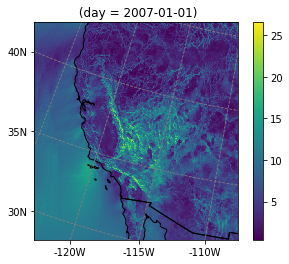

In [13]:
ds_daily.isel(day=0).salem.quick_map()

In [9]:
## target image
t_f = xr.open_dataarray('~/data/gridmet_ca_1km/bi_2001.nc')
t_f

<xarray.DataArray 'burning_index_g' (day: 365, lat: 1056, lon: 1145)>
[441328800 values with dtype=float32]
Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * lon      (lon) float64 -124.5 -124.5 -124.5 -124.5 ... -114.2 -114.2 -114.2
  * lat      (lat) float64 42.01 42.0 41.99 41.98 ... 32.56 32.55 32.54 32.53
Attributes:
    units:              Unitless
    description:        BI-G
    long_name:          bi
    standard_name:      bi
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    pyproj_srs:         +units=m +proj=latlong +datum=WGS84

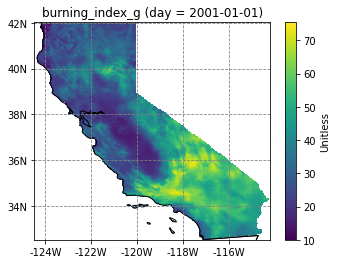

In [14]:
t_f.isel(day=0).salem.quick_map()

In [28]:
## transform
%%time
ds_t = t_f.salem.transform(ds_daily, interp='spline')

CPU times: user 7min 13s, sys: 3.75 s, total: 7min 17s
Wall time: 7min 17s


In [29]:
ds_t

<xarray.DataArray 'windspeed' (day: 365, lat: 1056, lon: 1145)>
array([[[ 4.176731 ,  4.179069 ,  4.209039 , ...,  6.8356934,
          6.7019672,  7.0601897],
        [ 4.1485295,  4.133708 ,  4.127569 , ...,  5.2363153,
          5.283621 ,  5.927599 ],
        [ 4.117719 ,  4.1102777,  4.0897856, ...,  5.2242975,
          5.3605604,  5.828035 ],
        ...,
        [       nan,        nan,        nan, ...,  7.7567124,
          7.673936 ,  7.5827484],
        [       nan,        nan,        nan, ...,  8.359672 ,
          7.994989 ,  7.8589277],
        [       nan,        nan,        nan, ...,  9.541208 ,
          9.062918 ,  8.623095 ]],

       [[ 8.825793 ,  8.837962 ,  8.823734 , ...,  4.899819 ,
          4.5560374,  5.089188 ],
        [ 8.790966 ,  8.805323 ,  8.799033 , ...,  3.9429553,
          3.6364565,  4.2713833],
        [ 8.754435 ,  8.767272 ,  8.773294 , ...,  3.9584706,
          4.142683 ,  4.467278 ],
        ...,
        [       nan,        nan,        nan, ...,  5.7981486,
          5.7568536,  5.7882547],
        [       nan,        nan,        nan, ...,  7.1918592,
          6.888519 ,  6.699911 ],
        [       nan,        nan,        nan, ...,  9.452993 ,
          9.165208 ,  8.526084 ]],

       [[16.109728 , 16.157324 , 16.201954 , ...,  4.8883924,
          5.2040324,  5.312094 ],
        [16.090014 , 16.12164  , 16.165554 , ...,  5.3927765,
          5.6058397,  5.852941 ],
        [16.11846  , 16.161434 , 16.203394 , ...,  5.727011 ,
          6.0061717,  6.502484 ],
        ...,
        [       nan,        nan,        nan, ...,  4.3611565,
          4.6655965,  5.270505 ],
        [       nan,        nan,        nan, ...,  5.104001 ,
          5.5252714,  6.415301 ],
        [       nan,        nan,        nan, ...,  6.502802 ,
          7.1484184,  7.7660522]],

       ...,

       [[10.609301 , 10.662407 , 10.698406 , ...,  8.376331 ,
          8.358514 ,  8.39403  ],
        [10.640228 , 10.577487 , 10.5726   , ...,  8.714332 ,
          8.593723 ,  8.486228 ],
        [10.868717 , 10.73508  , 10.633911 , ...,  8.839012 ,
          8.975791 ,  8.974084 ],
        ...,
        [       nan,        nan,        nan, ...,  1.7392764,
          1.7415118,  1.7480791],
        [       nan,        nan,        nan, ...,  2.0124137,
          1.9459903,  1.8836315],
        [       nan,        nan,        nan, ...,  2.4641588,
          2.3465333,  2.174005 ]],

       [[ 7.277844 ,  7.70675  ,  8.169837 , ..., 13.083496 ,
         13.231921 , 13.649868 ],
        [ 7.2217484,  7.770232 ,  8.285184 , ..., 13.396961 ,
         13.452674 , 13.478301 ],
        [ 7.6660824,  8.114728 ,  8.375014 , ..., 13.53797  ,
         14.022777 , 14.315334 ],
        ...,
        [       nan,        nan,        nan, ...,  2.0347686,
          1.9839512,  1.9687485],
        [       nan,        nan,        nan, ...,  2.4040222,
          2.297695 ,  2.184219 ],
        [       nan,        nan,        nan, ...,  3.1109052,
          2.918535 ,  2.6465292]],

       [[ 7.4500413,  7.6662617,  7.9741006, ..., 12.512159 ,
         12.636839 , 12.890025 ],
        [ 6.743881 ,  7.079632 ,  7.5728626, ..., 12.91362  ,
         12.817944 , 12.799384 ],
        [ 6.254987 ,  6.6487746,  6.9981346, ..., 13.430684 ,
         13.547981 , 13.498187 ],
        ...,
        [       nan,        nan,        nan, ...,  3.912898 ,
          4.244823 ,  4.555824 ],
        [       nan,        nan,        nan, ...,  4.5923786,
          5.0928903,  5.419084 ],
        [       nan,        nan,        nan, ...,  5.5631666,
          6.313865 ,  6.5879903]]], dtype=float32)
Coordinates:
  * day      (day) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lon      (lon) float64 -124.5 -124.5 -124.5 -124.5 ... -114.2 -114.2 -114.2
  * lat      (lat) float64 42.01 42.0 41.99 41.98 ... 32.56 32.55 32.54 32.53
Attributes:
    pyproj_srs:   +proj=longlat +datum=WGS84 +no_defs
    unit:         m/s
    description:  Windspeed at 1

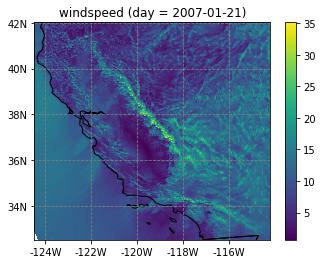

In [31]:
ds_t.isel(day=20).salem.quick_map()

In [32]:
ds_t.to_netcdf('/home/ubuntu/data/1km_gan_wind/nc/2007.nc')